# Introduction to text analysis IX #

### text clustering ###

In [1]:
import pickle
import string
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import re

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
stops_it = stopwords.words('italian')
stops_en = stopwords.words('english')

translator = str.maketrans(' ', ' ', string.punctuation) ## remove the punctuation

In [6]:
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))
docs_raw = newsgroups.data
print(len(docs_raw))

11314


** save the data for future use **

In [7]:
pickle.dump(docs_raw,open("20news.pickle","wb"))

** functions for text treatment **

In [8]:
def minimumSize(tokens,llen = 2):
    ## remove words smaller than llen chars
    tks = []
    for t in tokens:
        if(len(t) > llen):
            tks.append(t)
    return tks

def removeStops(tokens,stops = stops_it):
    # remove stop words
    remains = []
    for t in tokens:
        if(t not in stops):
            remains.append(t)
    return remains

def processText(text):
    ## tokenizer with stop words removal and minimum size 
    tks = word_tokenize(text)
    tks = [t.translate(translator) for t in tks] ## remove the punctuation
    tks = minimumSize(tks)
    tks = removeStops(tks,stops_en)
    return tks

In [9]:
n_features = 1000 
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,tokenizer=processText)

In [10]:
corpus = docs_raw[0:1000]


In [11]:

#tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf = tfidf_vectorizer.fit_transform(corpus)

** from the tfdif to the similarity of the documents **

In [12]:
pairwise_similarity = tfidf * tfidf.T ## scalar product

In [13]:
XD = pairwise_similarity.todense()

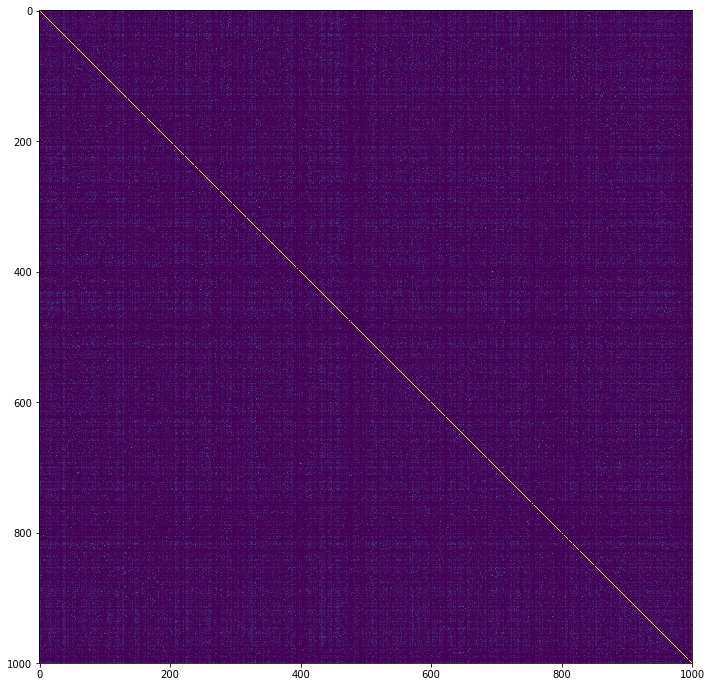

In [15]:
plt.figure(figsize=(12,12))
plt.imshow(XD)

In [16]:
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

In [17]:
true_k = 20

In [18]:
nn = Normalizer()
XN = nn.fit_transform(XD)

In [19]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,verbose=True)

In [20]:
km.fit(XN)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 654.129769901
start iteration
done sorting
end inner loop
Iteration 1, inertia 633.68920144
start iteration
done sorting
end inner loop
Iteration 2, inertia 626.289705032
start iteration
done sorting
end inner loop
Iteration 3, inertia 622.120552593
start iteration
done sorting
end inner loop
Iteration 4, inertia 618.930224985
start iteration
done sorting
end inner loop
Iteration 5, inertia 617.164054076
start iteration
done sorting
end inner loop
Iteration 6, inertia 616.511378372
start iteration
done sorting
end inner loop
Iteration 7, inertia 616.009456245
start iteration
done sorting
end inner loop
Iteration 8, inertia 615.664954032
start iteration
done sorting
end inner loop
Iteration 9, inertia 615.583918294
start iteration
done sorting
end inner loop
Iteration 10, inertia 615.49155706
start iteration
done sorting
end inner loop
Iteration 11, inertia 615.461065158
start iteration
done sorting

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [21]:
tws = list(corpus) 
clusters = {}
idx = 0
for t in km.labels_:
    if(t in clusters):
        clusters[t].append(tws[idx])
    else:
        clusters[t]= [tws[idx]]
    idx += 1

In [22]:
for k,v in clusters.items():
    print(k,len(v))

0 1
1 111
2 56
3 62
4 13
5 13
6 176
7 5
8 4
9 45
10 163
11 19
12 78
13 5
14 15
15 64
16 112
17 10
18 34
19 14


In [23]:
for c in clusters[9]:
    print(c)
    print("########")


Yes.

(I am adamantly an environmentalist.  I will not use styrofoam table service.
Please keep that in mind as you read this post - I do not wish to attack
environmentalism)

A half truth is at least as dangerous as a complete lie.  A complete lie will
rarely be readily accepted, while a half truth (the lie subtly hidden) is more
powerfully offered by one who masquerades as an angel of light.

Satan has (for some people) loosened the grip on treating the earth as something
other than God's intricate handiwork, something other than that on which the
health of future generations is based.  It is being treated with respect.  You
think he's going to happily leave it at that?  No.  When one error is rejected,
it is his style to push people to the opposite error.  Therefore the earth is
not God's intricate handiwork, not because it is rubbish, but because it is
God.  Mother earth is the one you are to primarily love and serve.

I see two facets of a response to it:

1: Care for the environ

### how to get the optimal number of clusters ###

** the Elbow method **

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

In [25]:
scores = []
distortions = []
rng = range(2,30,1)
for t in rng:
    km = KMeans(n_clusters=t, init='k-means++', max_iter=100, n_init=1,verbose=False)
    km.fit(XD)

    distortions.append( km.inertia_ )
    if(t%10 == 0):
        print(t)

10
20


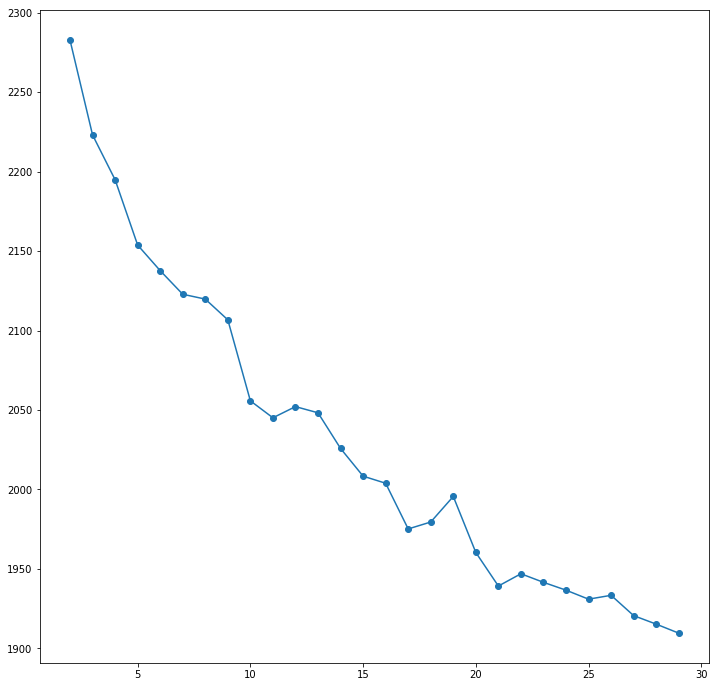

In [26]:
plt.figure(figsize=(12,12))
plt.plot( rng,distortions,marker="o")

** considerations **

Ideally the plot it will show a point where the slope changes, the point where there is a change is the "elbow" and this is the optimal point (if any) 